# <span style="color:green"> -------PERSONALITY SEGMENTATION---------- </span> 

In [1]:
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
PW = 8
PH = 6
plt.rcParams['figure.figsize'] = (PW, PH) 
plt.rcParams['image.cmap'] = 'gray'

import re
import pandas as pd 
pd.options.display.max_rows = 250
pd.options.display.max_columns = 500
pd.options.display.max_colwidth = 500

from nltk.tokenize import RegexpTokenizer #Natural Language Toolkit (NLTK) for natural language processing. 
from nltk.stem.snowball import SnowballStemmer
import string 
import warnings

## dataset
#### https://www.kaggle.com/datasnaek/mbti-type

In [2]:
df = pd.read_csv(r"C:\Users\MSI\Desktop\Data Science\Python\Projects\personality\mbti_1.csv", encoding="utf-8")
print("number of users", len(df))

number of users 8675


## <span style="color:green"> EDA </span>

In [3]:
df.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments https://www.youtube.com/watch?v=iz7lE1g4XM4 sportscenter not top ten plays https://www.youtube.com/watch?v=uCdfze1etec pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8 http://www.youtube.com/watch?v=u8ejam5DP3E On repeat for most of today.|||May the PerC Experience immerse you.|||The last ...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin* That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This...
2,INTP,"'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of course, to which I say I know; that's my blessing and my curse.|||Does being absolutely positive that you and your best friend could be an amazing couple count? If so, than yes. Or it's more I could be madly in love in case I reconciled my feelings (which at...|||No, I didn't; thank you for a link!|||So-called Ti-Si loop (and it can stem from any current topic/obsession) can be deadly. It's like when you're stuck in your o..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the other day. Esoteric gabbing about the nature of the universe and the idea that every rule and social code being arbitrary constructs created...|||Dear ENTJ sub, Long time no see. Sincerely, Alpha|||None of them. All other types hurt in deep existential ways that I want no part of.|||Probably a sliding scale that depends on individual preferences, like everything in humanity.|||Draco Malfoy also. I'd say he's either 358 or 368.|||I'm either 358..."
4,ENTJ,'You're fired.|||That's another silly misconception. That approaching is logically is going to be the key to unlocking whatever it is you think you are entitled to. Nobody wants to be approached with BS...|||But guys... he REALLY wants to go on a super-duper-long-ass vacation. C'mon guys. His boss just doesn't listen or get it. He even approached him logically and everything.|||Never mind. Just go on permanent vacation.|||Two months? I wouldn't be crazy about the idea. If you are really hi...
5,INTJ,"'18/37 @.@|||Science is not perfect. No scientist claims that it is, or that scientific information will not be revised as we discover new things. Rational thinking has been very useful to our society....|||INFP- Edgar Allen Poe was an INFP and he's in your siggy.|||People see the obvious Fi and are quick to put her as INFP. I agree that she has no Ne. I see her as an ISFP. Compare her to Haku (definite INFP). She is flat through most of Naruto.. but I don't...|||Lets get this party star..."
6,INFJ,"'No, I can't draw on my own nails (haha). Those were done by professionals on my nails. And yes, those are all gel. You mean those you posted were done by yourself on your own nails? Awesome!|||Probably the Electronic Screen Syndrome. With the advent of technology and social media, we all suffer from overstimulation on a daily basis. I'm guilty as well. In the past, I can be happy just...|||I love nail arts too! These are some of mine: 718282 718290 718298 718306 718314|||This is the first..."
7,INTJ,"'I tend to build up a collection of things on my desktop that i use frequently and then move them into a folder called 'Everything' from there it get sorted into type and sub type|||i ike to collect odd objects, even at work...a lot of people would call it junk but i like to collect it. Old unused software? ill take that off your hands :) i have a bunch of old adobe...|||i think its quite normal, i tend to only see my friends in real life every c

In [4]:
df.columns

Index(['type', 'posts'], dtype='object')

In [5]:
#Make the analysis easier by grouping the type of personalities and the number of post they have
groups = df.groupby("type").count()
groups.sort_values("posts", ascending= False, inplace=True)

ValueError: too many values to unpack (expected 2)

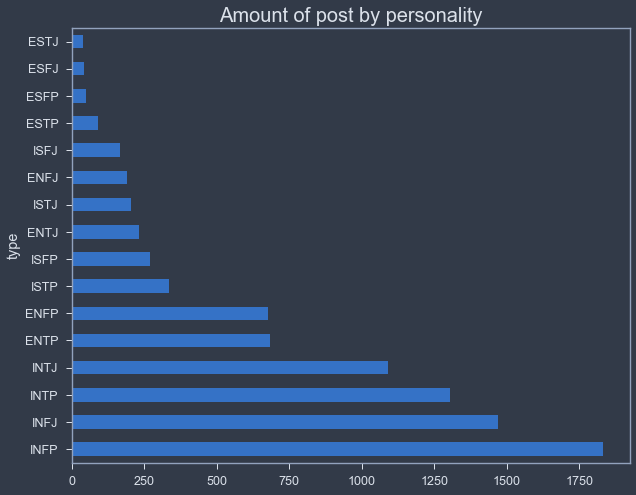

In [6]:
#Quickly see this graphically 
groups['posts'].plot(kind = 'barh',
                    figsize = (10, 8)
                    )
plt.title("Amount of post by personality", fontsize = 20)
plt.ylim('personality')
#The majority of post come from the INFP personality

In [7]:
#Obtain the proportion of each personality for Random Guessing Estimation
proportion = groups['posts']/groups['posts'].sum()
proportion

type
INFP    0.211182
INFJ    0.169452
INTP    0.150317
INTJ    0.125764
ENTP    0.078963
ENFP    0.077810
ISTP    0.038847
ISFP    0.031239
ENTJ    0.026628
ISTJ    0.023631
ENFJ    0.021902
ISFJ    0.019135
ESTP    0.010259
ESFP    0.005533
ESFJ    0.004841
ESTJ    0.004496
Name: posts, dtype: float64

In [8]:
#Length of the posts 
df['lenPre'] = df["posts"].apply(len)

C:\Users\MSI\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Lengths of all 50 Posts')

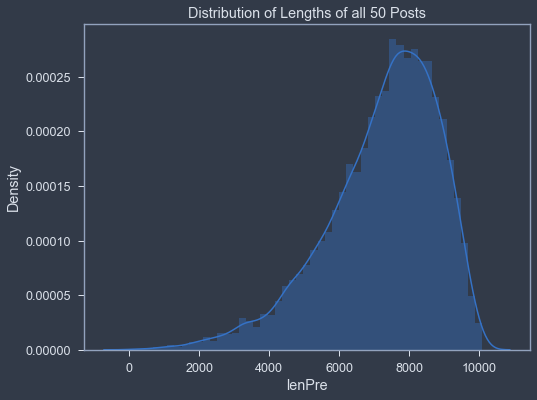

In [9]:
#Another more, pretty way
sns.distplot(df["lenPre"]).set_title("Distribution of Lengths of all 50 Posts")

## <span style="color:green"> TEXT PREPROCESSING </span>

In [10]:
def preprocess_text(df, remove_special=True):
    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep EOS
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #To lower
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove short/long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove Personality Types Words
    #This is crutial in order to get valid model accuracy estimation for unseen data. 
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")

    df["posts"] = df["posts"].apply(lambda x: p.sub(' PTypeToken ',x))
    return df

In [11]:
#Used for class balancing. When class balancing is used dataset becomes very small.
def subsample(df):
    groups = df.groupby("type").count()
    groups.sort_values("posts", ascending=False, inplace=True)
    
    min_num = groups["posts"][-1]
    min_ind = groups.index[-1]
    ndf = df[df["type"] == min_ind]

    for pt in groups.index[:-1]:
        print(min_num,pt)
        tdf = df[df["type"] == pt].sample(min_num)
        ndf = pd.concat([ndf, tdf])
    return ndf

##### With the regex functions defined,  is necessary to modify the text

C:\Users\MSI\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Number of Posts per User')

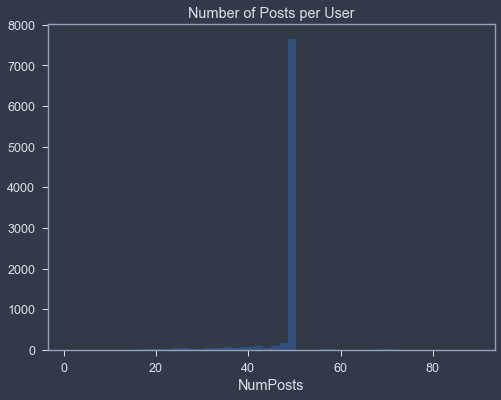

In [12]:
#Number of Posts per User
df["NumPosts"] = df["posts"].apply(lambda x: len(x.split("|||")))

sns.distplot(df["NumPosts"], kde=False).set_title("Number of Posts per User")

In [13]:
#Split to posts
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
df.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(df))
print("Number of posts", len(posts))

df = pd.DataFrame(posts, columns=["type", "posts"])

Number of users 8675
Number of posts 422845


In [14]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg
2,INFJ,enfp and intj moments https://www.youtube.com/watch?v=iz7lE1g4XM4 sportscenter not top ten plays https://www.youtube.com/watch?v=uCdfze1etec pranks
3,INFJ,What has been the most life-changing experience in your life?
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 http://www.youtube.com/watch?v=u8ejam5DP3E On repeat for most of today.


C:\Users\MSI\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


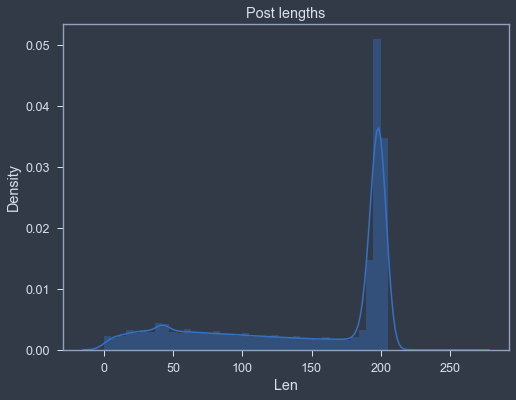

In [15]:
df["Len"] = df["posts"].apply(len)
sns.distplot(df["Len"]).set_title("Post lengths");

In [16]:
#preprocessed text
df = preprocess_text(df)

C:\Users\MSI\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Post lengths')

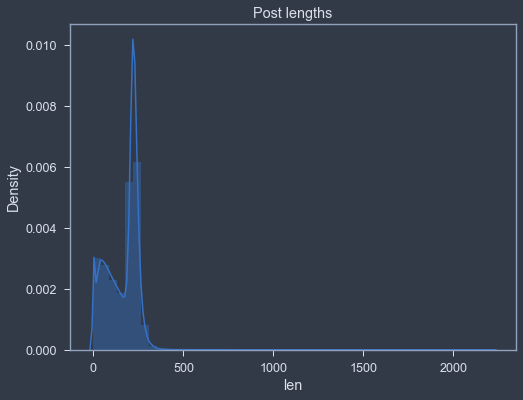

In [17]:
df['len'] = df['posts'].apply(len)
sns.distplot(df['len']).set_title("Post lengths")

In [18]:
#Remove posts with less than X words
min_words = 15
print("Number of posts", len(df)) 
df["nw"] = df["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
df = df[df["nw"] >= min_words]
print("Number of posts", len(df))

Number of posts 422845
Number of posts 275034


C:\Users\MSI\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Post lenght')

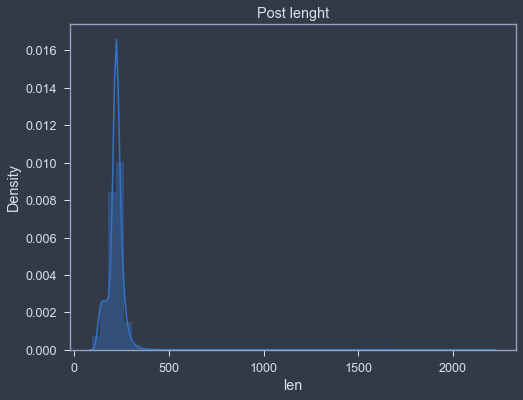

In [19]:
sns.distplot(df['len']).set_title("Post lenght")

In [20]:
#Drop nw Len
df.drop(["nw", "Len"],axis=1, inplace=True)

## <span style="color:green"> WORD STEMMING </span> 

In [21]:
stemmer = SnowballStemmer("english")
df["posts"] = df["posts"].apply(lambda x: " ".join(stemmer.stem(p) for p in x.split(" ")))

In [22]:
df.iloc[np.random.choice(len(df),10),:]

,type,posts,len
287492,ENFP,eostokenquest must kid right eostokenquest eostokendot experiment film cost under with prop shoot becaus hire free equip dure univers cours eostokendot,193
203962,ISTJ,nice touch eostokendot eostokendot eostokendot think unedit version probabl more ptypetoken motto which teacher defin eostokendot,156
146686,INFJ,this where start eostokendot this point need creat your lane eostokendot howev there part that addict drama without go deep eostokendot eostokendot eostokendot eostokendot,215
386316,ENTJ,there were also ptypetoken have seen same stat past eostokendot doe ptypetoken make sens eostokenquest what would look like eostokenquest like focus practic when eostokendot eostokendot eostokendot,243
407440,ENTP,wonder about would trityp work someon balanc wing their enneagram type eostokendot exampl balanc could enneagram trityp like this eostokenquest eostokendot eostokendot eostokendot,220
242473,INTJ,eostokendot definit dont have lifetim plan becaus mani thing want never well happen cant make them happen like get marri have famili chiefli that eostokendot eostokendot eostokendot,219
98691,ESFP,would rather egoless peopl easili control eostokendot control defens mechan selfident eostokendot which lead set person boundari eostokendot diminish actual cult eostokendot eostokendot eostokendot,247
283192,ENTP,nope eostokendot eostokendot eostokendot introvert ptypetoken curious know what about that make think though eostokenquest,143
22890,INFP,irish italian eostokendot born australia irish famili came australia from singapor kept bit piec that cultur eostokendot consid myself australian eostokendot exream eostokendot eostokendot eostokendot,236
327697,INFJ,confid come goe veri quick everi eostokendot hour there full forc then shaken next eostokendot determin great audienc unfortun eostokendot think use have both eostokendot eostokendot eostokendot,240


## <span style="color:green"> BAG OF WORDS </span>

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [24]:
vect = CountVectorizer(stop_words='english') 
X =  vect.fit_transform(df["posts"]) 

le = LabelEncoder()
y = le.fit_transform(df["type"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

## <span style="color:green"> Word Lengths Disttribution </span>

C:\Users\MSI\anaconda3\envs\tensorflow\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


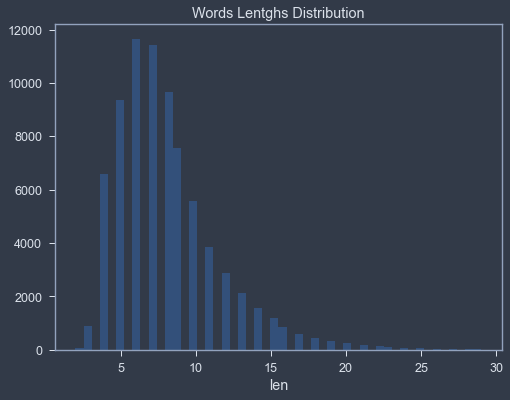

In [25]:
wdf = pd.DataFrame( vect.get_feature_names(),columns=["word"])
wdf["len"] = wdf.word.apply(len)
sns.distplot(wdf["len"], kde=False).set_title("Words Lentghs Distribution");

# <span style="color:green"> Sequential Models </span>

In [26]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense,  Dropout, Flatten
from keras.layers import LSTM, Conv1D, Input, MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.preprocessing import OneHotEncoder

from scipy import spatial
from sklearn.utils import class_weight

C:\Users\MSI\anaconda3\envs\tensorflow\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\MSI\anaconda3\envs\tensorflow\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\MSI\anaconda3\envs\tensorflow\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\MSI\anaconda3\envs\tensorflow\lib\

In [42]:
def cat_accu_seq(X_test, y_test, model):
    yp_test = model.predict(X_test)
    yp_test_d =  np.argmax(yp_test, axis=1)
    y_test_d =  np.argmax(y_test, axis=1)
    return  cat_accuracy(yp_test_d, y_test_d, le )

In [27]:
def calc_weights(df, le, ohe):
    groups = df.groupby("type").count()
    groups.sort_values("posts", ascending=False, inplace=True)
    
    p = groups["posts"]#.to_dict()
    ohe.transform([[x] for x in le.transform(p.index.values)])

In [28]:
X =  df.posts

le = LabelEncoder()
y = le.fit_transform(df["type"])

ohe = OneHotEncoder(categories='auto',  sparse=False)
y = ohe.fit_transform(y.reshape(-1, 1))

In [29]:
#Tokenize words
max_nb_words = 200000

tokenizer = Tokenizer(num_words=max_nb_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 77808 unique tokens.


In [30]:
#Retokenize
max_nb_words = len(word_index)
tokenizer = Tokenizer(num_words=max_nb_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [31]:
#Constants
ptypes_num = 16
max_post_len = np.max([ len(x) for x in sequences])

In [32]:
#Pad Sequence
sequences = sequence.pad_sequences(sequences, maxlen=max_post_len) 

In [33]:
#Split train and test set again, since que tokenized the values
X_train, X_test, y_train, y_test = train_test_split(sequences, y, test_size=0.1, stratify=y, random_state=42)

In [34]:
X_train.shape

(247530, 170)

In [35]:
X_test.shape

(27504, 170)

In [36]:
#Parameters
batch_size = 512
epochs = 5
embedding_vecor_length = 32
lstm_size = 32

In [37]:
#Model
model = Sequential()
model.add(Embedding(max_nb_words, embedding_vecor_length, input_length=max_post_len))
model.add(Dropout(0.25))

model.add(LSTM(lstm_size))
model.add(Dropout(0.25))

model.add(Dense(ptypes_num, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 170, 32)           2489856   
_________________________________________________________________
dropout (Dropout)            (None, 170, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
Total params: 2,498,704
Trainable params: 2,498,704
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.23.2


In [40]:
#Calculate Class Weights
# wy = le.fit_transform(df["type"])
# cw = class_weight.compute_class_weight('balanced', np.unique(wy), wy) #problems with np.unique

#Fit Model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test));

C:\Users\MSI\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15], y=[8 8 8 ... 9 9 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Epoch 1/5
484/484 [==============================] - 127s 258ms/step - loss: 2.3867 - accuracy: 0.1866 - val_loss: 2.2459 - val_accuracy: 0.2185
Epoch 2/5
484/484 [==============================] - 124s 255ms/step - loss: 2.2344 - accuracy: 0.2228 - val_loss: 2.2223 - val_accuracy: 0.2278
Epoch 3/5
484/484 [==============================] - 132s 273ms/step - loss: 2.1893 - accuracy: 0.2439 - val_loss: 2.2172 - val_accuracy: 0.2368
Epoch 4/5
484/484 [==============================] - 133s 275ms/step - loss: 2.1458 - accuracy: 0.2650 - val_loss: 2.2296 - val_accuracy: 0.2350
Epoch 5/5
484/484 [==============================] - 135s 279ms/step - loss: 2.0988 - accuracy: 0.2893 - val_loss: 2.2466 - val_accuracy: 0.2342


In [46]:
scores_tr = model.evaluate(X_train, y_train, verbose=0)
scores_ts = model.evaluate(X_test, y_test, verbose=0)

print("Train Accuracy:",scores_tr[1])
print("Test Accuracy:", scores_ts[1])
# print("******")
# print("Categorical Train accuracy:", cat_accu_seq(X_train, y_train, model))
# print("Categorical Test Accuracy:", cat_accu_seq(X_test, y_test, model))

Train Accuracy: 0.32882073521614075
Test Accuracy: 0.2341841161251068


# Predictions

In [44]:
yp_test =  np.argmax(model.predict(X_test), axis=1)

dft = pd.DataFrame(le.inverse_transform(yp_test),columns=["pred"])
dft["cnt"] =  1
dft["same"] = (yp_test == np.argmax(y_test, axis=1))
dft["same"] = dft["same"].astype(int)

groupsn = dft.groupby("pred").sum()
groupsn.sort_values("cnt", ascending=False, inplace=True)

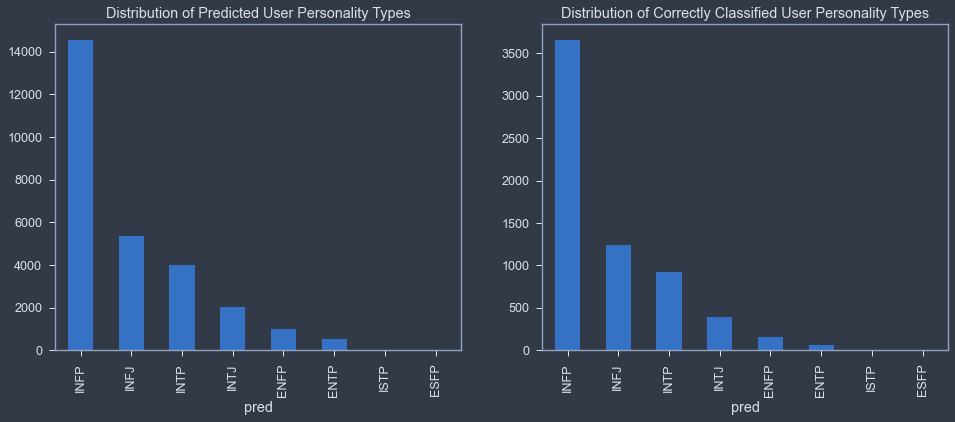

In [45]:
f, ax = plt.subplots(1,2,figsize=(2*PW,PH))
groupsn["cnt"].plot(kind="bar", title="Predicted User Personality Types", ax=ax[0]);
groupsn["same"].plot(kind="bar", title="Correctly Classified User Personality Types", ax=ax[1]);